In [1]:
# region Init

print("Loading libraries...")

#* --------------------------------------------------------------------------------
#* General purpose imports
#* --------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from astroquery.sdss import SDSS

from scipy.stats import multivariate_normal
import scipy.interpolate as interp

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines  # for legend proxies
import matplotlib.ticker as ticker

import seaborn as sns

import time 
import re 
from io import StringIO

from tqdm import tqdm
tqdm.pandas()

#* --------------------------------------------------------------------------------
#* Personal librairies imports
#* --------------------------------------------------------------------------------
import sys, os
src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)
from utils import astro_utils as au
from utils import maths_utils  as mu
from utils import stats_utils  as su
from utils import graphics_utils  as gu
from utils import labels_utils  as lu

#* --------------------------------------------------------------------------------
#* Global variables
#* --------------------------------------------------------------------------------
import config as co

#* --------------------------------------------------------------------------------
#* Project functions imports
#* --------------------------------------------------------------------------------
import data_loader as dl
import plots
import generate_report as report
import sSFR



print("Done")


#* --------------------------------------------------------------------------------
#* Global variables
#* --------------------------------------------------------------------------------
global Control_withAGN, CG_all, CG_withAGN, Control

#* --------------------------------------------------------------------------------
#* Functions
#* --------------------------------------------------------------------------------

def load_data(Verbose=True):
    Control_withAGN = dl.load_SDSS()
    CG_all = dl.import_CG(Control_withAGN)

    if Verbose:
        print(f"   {len(Control_withAGN)} galaxies loaded from the SDSS database")
        print("\n")
        for cat in CG_all.keys():
            print(f"   {len(CG_all[cat])} galaxies loaded from {cat}")

    return Control_withAGN, CG_all

def select_data(Control_withAGN, CG_all, Verbose=True):
    #* --------------------------------------------------------------------------------
    #* Selecting the CG galaxies in the z, R limits
    #* and add SDSS information
    #* --------------------------------------------------------------------------------
    CG_withAGN = {}
    for cat in CG_all.keys():
        df = CG_all[cat]
        df_sel = dl.intersect_and_enrich(df, Control_withAGN)
        CG_withAGN[cat] = df_sel
        if Verbose:
            print(f"   {cat}: {len(df_sel)} galaxies left after cuts (z between {co.Z_MIN} and {co.Z_MAX}, R < {co.R_MAX})")
    
    return CG_withAGN

def select_nonAGN(Control_withAGN, CG_withAGN, Verbose=True):
    Control = dl.remove_AGN(Control_withAGN)
    if Verbose:
        print(f"   {len(Control)} galaxies left after removing AGN")
    CG = {}
    for cat in CG_withAGN.keys():
        CG[cat] = dl.remove_AGN(CG_withAGN[cat])
        if Verbose:
            print(f"   {cat}: {CG[cat]} galaxies left after removing AGN")

    return Control, CG

    
# endregion

    

Loading libraries...
Done


In [2]:
# region Data

print("Loading data...")
Control_withAGN, CG_all = load_data()

print("Selecting data...")
CG_withAGN = select_data(Control_withAGN, CG_all)

print("Removing AGN...")
Control, CG = select_nonAGN(Control_withAGN, CG_withAGN)

# endregion

Loading data...
Querying the SDSS database...
78711 galaxies retrieved.
NB: physical parameters come from MPA-JHU spectroscopic catalogue
Importing CG galaxies
   5228 galaxies read from gal_in_CG_new.dat-3-dv1
      3.0e-03 <= z <= 1.3e-01
      9.70 <= r <= 17.72
   4878 galaxies read from gal_in_CG_new.dat-3-dv5
      3.0e-03 <= z <= 1.2e-01
      9.70 <= r <= 17.72
   2242 galaxies read from gal_in_CG_new.dat-4-dv1
      3.6e-03 <= z <= 1.3e-01
      10.59 <= r <= 17.69
   1888 galaxies read from gal_in_CG_new.dat-4-dv5
      3.6e-03 <= z <= 1.2e-01
      10.59 <= r <= 17.69
Done
   78711 galaxies loaded from the SDSS database


   5228 galaxies loaded from 3_1000
   4878 galaxies loaded from 3_500
   2242 galaxies loaded from 4_1000
   1888 galaxies loaded from 4_500
Selecting data...
   3_1000: 3507 galaxies left after cuts (z between 0.005 and 0.0452, R < 17.77)
   3_500: 3300 galaxies left after cuts (z between 0.005 and 0.0452, R < 17.77)
   4_1000: 1429 galaxies left after cu

In [3]:
def fit_gmm(catalogue, verbose=True):
    """
    Fit a Gaussian Mixture Model to the data.

    Suppose that AGN have already been filtered out.
    Expects the catalogue to contain the following columns:
    - 'lgm': log of the stellar mass
    - 'sSFR': specific star formation rate

    Parameters  
    ----------
    catalogue : pandas.DataFrame
        DataFrame containing the data to fit.
    verbose : bool
        If True, print the results of the fit.
    Returns
    -------
    -------
    fit_results : dict
        Dictionary containing the results of the fit.   
    """
    

    #* --------------------------------------------------------------------------------
    #* Cleaning the data to exclude Quenched and invalid M*
    #* --------------------------------------------------------------------------------

    cat = catalogue.copy()
    cat = cat.dropna(subset=['sSFR', 'lgm'])
    cat = cat[cat['lgm'] > 0]



    #* --------------------------------------------------------------------------------
    #* Convert data to NumPy arrays (removed PyTorch usage).
    #* Here we keep the raw and optionally normalized versions if needed.
    #* --------------------------------------------------------------------------------
    non_quenched = cat.loc[cat['sSFR'] > -1000]
    X = non_quenched[['lgm', 'sSFR']].values

    #* Example optional normalization using NumPy:
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_normalized = (X - X_mean) / (X_std + 1e-8)  #* Add small epsilon to avoid zero div


    #* --------------------------------------------------------------------------------
    #* Set random seed for reproducibility
    #* --------------------------------------------------------------------------------
    np.random.seed(421)



    #* --------------------------------------------------------------------------------
    #* Fit and visualize the GMM on our non-AGN data.
    #* --------------------------------------------------------------------------------
    start_time = time.time()
    fit_results = su.fit_gmm(X)
    if verbose:
        print(f"   GMM fitting completed in {time.time() - start_time:.2f} seconds")
    return fit_results

In [4]:
def get_decision_boundary_interp(non_quenched, fit_results, boundary_margin=0.5, grid_points=200):
    """
    Computes an interpolation function f_interp from the decision boundary
    between star-forming and green valley galaxies.
    
    Parameters
    ----------
    non_quenched : pandas.DataFrame
        DataFrame with columns 'lgm' and 'sSFR'.
    fit_results : dict
        Dictionary with keys 'means', 'covs', and 'weights' from the GMM fit.
    boundary_margin : float, optional
        Extra margin to add/subtract when computing the grid limits.
    grid_points : int, optional
        Number of grid points for both x and y directions.
        
    Returns
    -------
    f_interp : function
        Interpolation function f_interp(mass) that returns the limiting sSFR.
    """
    # Extract GMM parameters.
    means = fit_results['means']
    covs = fit_results['covs']
    weights = fit_results['weights']
    
    # Assume the component with the higher sSFR (index 1) is star forming.
    starforming_idx = np.argmax([m[1] for m in means])
    nonstar_idx = 1 - starforming_idx
    
    # Set grid limits.
    x_min = non_quenched['lgm'].min() - boundary_margin
    x_max = non_quenched['lgm'].max() + boundary_margin
    y_min = non_quenched['sSFR'].min() - boundary_margin
    y_max = non_quenched['sSFR'].max() + boundary_margin
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_points),
                         np.linspace(y_min, y_max, grid_points))
    grid_points_arr = np.column_stack([xx.ravel(), yy.ravel()])
    
    p_star_grid = weights[starforming_idx] * multivariate_normal.pdf(
        grid_points_arr, mean=means[starforming_idx], cov=covs[starforming_idx], allow_singular=True)
    p_nonstar_grid = weights[nonstar_idx] * multivariate_normal.pdf(
        grid_points_arr, mean=means[nonstar_idx], cov=covs[nonstar_idx], allow_singular=True)
    pdf_diff = p_star_grid - p_nonstar_grid
    pdf_diff = pdf_diff.reshape(xx.shape)
    
    # Draw the zero contour (decision boundary) offscreen.
    fig_temp = plt.figure()
    contour = plt.contour(xx, yy, pdf_diff, levels=[0], colors='black', linestyles='--', linewidths=2)
    plt.close(fig_temp)
    
    # Extract contour coordinates (use the longest segment).
    segments = contour.allsegs[0]
    if len(segments) == 0:
        raise ValueError("No decision boundary contour found.")
    seg = max(segments, key=lambda s: s.shape[0])
    # Sort the segment by mass (first column)
    seg = seg[seg[:, 0].argsort()]
    
    # Create interpolation function: given a mass, return the limiting sSFR.
    f_interp = interp.interp1d(seg[:, 0], seg[:, 1], bounds_error=False, fill_value="extrapolate")
    return f_interp

In [5]:
# fit_results = fit_gmm(Control, verbose=True)
non_quenched = Control.loc[Control['sSFR'] > -1000]
fit_results = fit_gmm(non_quenched, verbose=True)
f_interp = get_decision_boundary_interp(non_quenched, fit_results)

Fitting GMM to original data...
Running initialization 1/5...
  Finished with KL divergence: 4.8537
  New best result found!
Running initialization 2/5...
  Finished with KL divergence: 4.8528
  New best result found!
Running initialization 3/5...
  Finished with KL divergence: 6.4900
Running initialization 4/5...
  Finished with KL divergence: 4.8528
  New best result found!
Running initialization 5/5...
  Finished with KL divergence: 7.2148
Original data KL divergence: 4.8528
   GMM fitting completed in 19.60 seconds


In [6]:
def flattens_quenched(row):
    # set sSFR to -15 if it is -9999
    if row['sSFR'] == -9999:
        return -15
    else:
        return row['sSFR']


In [7]:
def compute_component_prob(x, comp_idx, fit_results):
    means = fit_results['means']
    covs = fit_results['covs']
    weights = fit_results['weights']
    
    return weights[comp_idx] * multivariate_normal.pdf(x, mean=means[comp_idx], cov=covs[comp_idx], allow_singular=True)

def is_star_forming(cat, fit_results):
    """
    Classify galaxies in a catalogue as star-forming or not based on GMM parameters.
    
    Parameters
    ----------
    cat : pandas.DataFrame
        DataFrame containing the data to classify.
    fit_results : dict
        Dictionary with keys 'means', 'covs', and 'weights' from the GMM fit.
    
    Returns
    -------
    star_forming : list
        List of booleans indicating whether each galaxy is star-forming or not.
    """
    

    star_forming = []

    #* --------------------------------------------------------------------------------
    #* Extract GMM parameters.
    #* --------------------------------------------------------------------------------
    
    means = fit_results['means']
    covs = fit_results['covs']
    weights = fit_results['weights']
    
    #* --------------------------------------------------------------------------------
    #* Assume the component with the higher sSFR (index 1) is star forming.
    #* --------------------------------------------------------------------------------
    
    starforming_idx = np.argmax([m[1] for m in means])
    nonstar_idx = 1 - starforming_idx

    for x in cat[['lgm', 'sSFR']].values:
        p_star = compute_component_prob(x, starforming_idx, fit_results)
        p_nonstar = compute_component_prob(x, nonstar_idx, fit_results)
        star_forming.append(p_star >= p_nonstar)
   
    return star_forming


In [8]:
def sSFR_status(df):
    """
    Classify galaxies based on their sSFR status.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the data to classify.
    
    Returns
    -------
    None
    """
    
    #* --------------------------------------------------------------------------------
    #* Classify galaxies based on sSFR status.
    #* --------------------------------------------------------------------------------
    
    df['sSFR_status'] = 'quenched'
    df.loc[df['sSFR'] > -9999, 'sSFR_status'] = 'passive'
    df.loc[~df['is_star_forming'], 'sSFR_status'] = 'star-forming'


    return df['sSFR_status']
#* --------------------------------------------------------------------------------

In [9]:
# region sSFR status
for df in [Control] + [CG[cat] for cat in CG.keys()]:
    df['is_star_forming'] = is_star_forming(df, fit_results)
    df['sSFR_status'] = sSFR_status(df)
    
    df.drop(columns=['is_star_forming'], inplace=True)
    df['sSFR_raw'] = df['sSFR']
    df['sSFR'] = df.apply(flattens_quenched, axis=1)
# endregion

In [10]:
def plot_galaxy_sfr(catalogue, markerscale=8, triangle_factor=0.7, save_path=None, figsize=(10, 8),
                   fontsize_labels=16, fontsize_legend=14, CG_type='4_500'):
    """
    Create a scatter plot of galaxy sSFR vs stellar mass using subplots.
    
    Parameters:
    -----------
    catalogue : pandas DataFrame
        The galaxy catalogue containing 'lgm', 'sSFR', and 'sSFR_status' columns
    markerscale : float, default=8
        Scale factor for the size of markers in the legend for scatter points
    triangle_factor : float, default=0.7
        Factor to make triangles smaller than dots in the legend (relative to markerscale)
    save_path : str, optional
        If provided, save the figure to this path as PDF
    figsize : tuple, default=(10, 8)
        Figure size in inches (width, height)
    fontsize_labels : int, default=16
        Font size for axis labels
    fontsize_legend : int, default=14
        Font size for legend text
    CG_type : str, default='4_500'
        Type of CG data to filter
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    # Filter catalogue for valid mass values
    catalogue = catalogue.loc[catalogue['lgm'] > 0]
    
    # Create a copy of the dataframe with capitalized sSFR_status for the legend
    plot_data = catalogue.copy()
    plot_data['sSFR_status'] = plot_data['sSFR_status'].apply(lambda x: x.capitalize())
    
    # Create figure and axis objects
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create the scatter plot for main catalogue with capitalized labels
    sns.scatterplot(
        data=plot_data,
        x='lgm',
        y='sSFR',
        hue='sSFR_status',
        palette={'Quenched': 'red', 'Passive': 'green', 'Star-forming': 'blue'},
        alpha=0.5,
        s=1,
        ax=ax,
        legend=False  # Don't create a legend yet
    )
    
    # Create a new legend with proper sizes for dot markers
    dot_legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                  markersize=markerscale, label='Quenched', alpha=0.7),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                  markersize=markerscale, label='Passive', alpha=0.7),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                  markersize=markerscale, label='Star-forming', alpha=0.7)
    ]
    
    # If CG data is provided, add it as empty black triangles
    if CG_type is not None:
        CG_filtered = CG[CG_type]
        
        # Filter CG data for valid mass values
        CG_filtered = CG_filtered.loc[CG_filtered['lgm'] > 0]
        
        # Plot CG data as empty triangles
        ax.scatter(
            CG_filtered['lgm'],
            CG_filtered['sSFR'],
            edgecolor='black',
            facecolor='none',
            marker='^',
            s=15,  # Size for the actual data points
            alpha=0.7,
            linewidth=1
        )
        
        # Add triangle to legend elements with a smaller size
        triangle_legend_element = plt.Line2D([0], [0], marker='^', color='w', 
                                           markeredgecolor='black', markerfacecolor='none',
                                           markersize=markerscale * triangle_factor, 
                                           label='Compact Groups galaxies', alpha=0.7)
        dot_legend_elements.append(triangle_legend_element)
    
    # Create the legend with our custom elements
    ax.legend(handles=dot_legend_elements, fontsize=fontsize_legend)
    
    # Set axis labels with larger font
    ax.set_xlabel(r'$\log(M_*/M_\odot)$', fontsize=fontsize_labels)
    ax.set_ylabel('sSFR [yr⁻¹]', fontsize=fontsize_labels)

    # Also increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=fontsize_labels-2)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure if a path is provided
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    return fig, ax

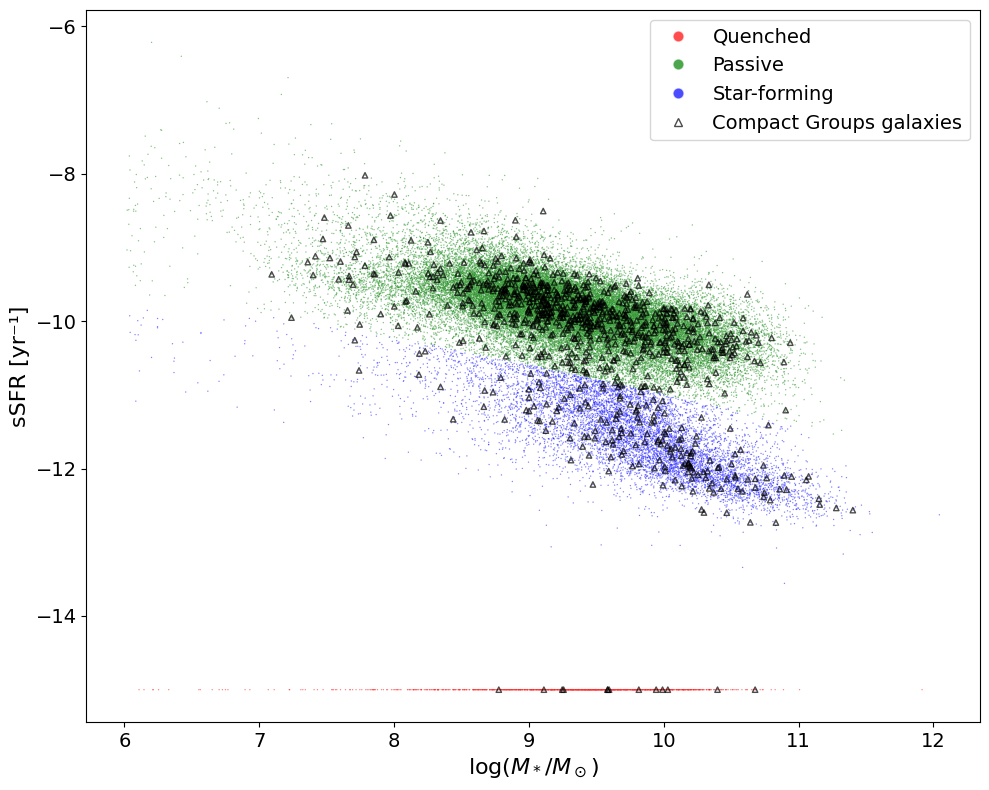

In [11]:
fig, ax = plot_galaxy_sfr(Control, save_path='galaxy_sfr_plot.pdf')

In [12]:
Control.name = 'Control'
for cat in CG.keys():
    CG[cat].name = cat

for df in [Control] + [CG[cat] for cat in CG.keys()]:
    print(f"{df.name}")
    df_lgm = df[df['lgm'] > 0]
    for status in df['sSFR_status'].unique():
        df_status = df_lgm[df_lgm['sSFR_status'] == status]
        print(f"   {status}: {100*len(df_status)/len(df):.1f} % ")

Control
   passive: 83.0 % 
   star-forming: 14.5 % 
   quenched: 2.4 % 
3_1000
   passive: 80.4 % 
   star-forming: 17.7 % 
   quenched: 1.8 % 
3_500
   passive: 80.9 % 
   star-forming: 17.5 % 
   quenched: 1.5 % 
4_1000
   passive: 78.9 % 
   star-forming: 19.7 % 
   quenched: 1.4 % 
4_500
   passive: 79.5 % 
   star-forming: 19.0 % 
   quenched: 1.4 % 


In [13]:
from scipy.stats import fisher_exact, barnard_exact

df1 = Control[Control['lgm'] > 0]
df2 = CG['4_500'][CG['4_500']['lgm'] > 0]
df1_starforming = df1[df1['sSFR_status'] == 'star-forming']
df2_starforming = df2[df2['sSFR_status'] == 'star-forming']
table = [[len(df1_starforming), len(df1)],[len(df2_starforming), len(df2)]]


print("Exact test p-values of proportion of star forming being different between CG_4_500 and control sample:")
res_fisher = fisher_exact(table, alternative='two-sided')
print(f"   Fisher: {res_fisher.pvalue:.1e}")
if res_fisher.pvalue < 0.05:
    print("   Reject null hypothesis: the proportion of star forming galaxies is different between CG_4_500 and control sample")
    print(f"   Control proportion of star forming ({100*len(df1_starforming)/len(df1):.1f}%) " + 
          f"is different from CG_4_500 proportion of star forming ({100*len(df2_starforming)/len(df2):.1f}%)")
else:
    print("   Fail to reject null hypothesis: the proportion of star forming galaxies is not different between " + 
          "CG_4_500 and control sample")



Exact test p-values of proportion of star forming being different between CG_4_500 and control sample:
   Fisher: 1.6e-03
   Reject null hypothesis: the proportion of star forming galaxies is different between CG_4_500 and control sample
   Control proportion of star forming (14.6%) is different from CG_4_500 proportion of star forming (19.0%)


In [14]:
# region Merge data from Tempel
print("Importing Tempel groups")


Tempel = pd.read_csv(co.DATA_PATH+"Tempel/table1.dat",sep=r'\s+',header=None,index_col=None)
Tempel.rename(columns=
                    {0  : "GalID",
                     1  : "specObjID",
                     2  : "objid",
                     3  : "GroupID",
                     4  : "Ngal",
                     5  : "Rank",
                     6  : "Dist.g",
                     7  : "zobs",
                     8  : "zcmb",
                     9  : "e_zobs",
                     10  : "Dist",
                     11  : "Distcor",
                     12  : "RAdeg",
                     13  : "DEdeg",
                     14  : "GLON",
                     15  : "GLAT",
                     16  : "SGLON",
                     17  : "SGLAT",
                     18  : "lambda",
                     19  : "eta",
                     20  : "Xpos",
                     21  : "Ypos",
                     22  : "Zpos",
                     23  : "umag",
                     24  : "gmag",
                     25  : "rmag",
                     26  : "imag",
                     27  : "zmag",
                     28  : "uMAG",
                     29  : "gMAG",
                     30  : "M_r",
                     31  : "iMAG",
                     32  : "zMAG",
                     33  : "k+e.u",
                     34  : "k+e.g",
                     35  : "k+e.r",
                     36  : "k+e.i",
                     37  : "k+e.z",
                     38  : "ext.u",
                     39  : "ext.g",
                     40  : "ext.r",
                     41  : "ext.i",
                     42  : "ext.z",
                     43  : "Lr",
                     44  : "w",
                     45  : "pE",
                     46  : "pS0",
                     47  : "pSa",
                     48  : "pSc",
                     49  : "Dist.e",
                     50  : "Den1",
                     51  : "Den2",
                     52  : "Den4",
                     53  : "Den8"
                    },inplace=True)
print("%i galaxies imported"%Tempel.shape[0])
duplicate_nb = Tempel['objid'].value_counts()[Tempel['objid'].value_counts()> 1].shape[0]
print("%i duplicate(s)"%duplicate_nb)
if (duplicate_nb>0):
    print("Dropping duplicates")
    Tempel=Tempel.loc[~Tempel.duplicated(subset=['objid'], keep='first')]
    print("Done. %i galaxies left"%Tempel.shape[0])
print("Done")


print("Merging groups caracteristics with galaxy list")
CG_Gals = CG['4_500'].copy()
CG_Gals.rename(columns={'idcg':'Group'}, inplace=True)
CG_Gals = CG_Gals.merge(Tempel,on='specObjID', how='left')
CG_Gals.rename(columns={'GroupID':'GroupID_Tempel'}, inplace=True)


# 1) Compute pS safely by treating missing pSa/pSc as zero
CG_Gals['pS'] = (
    CG_Gals['pSa'].fillna(0) +
    CG_Gals['pSc'].fillna(0)
)

# 2) Fill any remaining NA in the key columns with zero
CG_Gals[['pE','pS0','pS']] = (
    CG_Gals[['pE','pS0','pS']]
      .fillna(0)
)

# 3) idxmax will now operate without warnings
best = CG_Gals[['pE','pS0','pS']].idxmax(axis=1)

# 4) Map to your final Morphology labels
label_map = {'pE':'E', 'pS0':'S0', 'pS':'S'}
CG_Gals['Morphology'] = best.map(label_map)

# endregion

Importing Tempel groups
584449 galaxies imported
0 duplicate(s)
Done
Merging groups caracteristics with galaxy list


In [15]:
def plot_galaxy_sfr_CG(
    CG_Gals,
    markerscale=8,
    save_path=None,
    figsize=(10, 8),
    fontsize_labels=16,
    fontsize_legend=14
    ):
    """
    Scatter of log(M*) vs sSFR for Compact‐Group galaxies only,
    coloured by sSFR_status and shaped by Morphology.
    """
    # 1) Filter out bad masses
    df = CG_Gals.loc[CG_Gals['lgm'] > 0].copy()
    
    # 2) Capitalize status and ensure Morphology exists
    df['sSFR_status'] = df['sSFR_status'].str.capitalize()
    # (assumes df['Morphology'] is already 'E', 'S0' or 'S')
    
    # 3) Define palette + marker mapping
    palette = {
        'Quenched': 'red',
        'Passive':  'green',
        'Star-forming': 'blue'
    }
    marker_map = {'E':'o', 'S0':'s', 'S':'^'}
    
    # 4) Draw scatter in one shot
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(
        data=df,
        x='lgm',
        y='sSFR',
        hue='sSFR_status',
        style='Morphology',
        palette=palette,
        markers=marker_map,
        s=markerscale**2,       # scatterplot `s` is area; adjust as needed
        alpha=0.7,
        ax=ax,
        legend='full'           # get separate entries for every combo 
    )
    
    # 5) Tidy up legend & axes
    ax.legend(fontsize=fontsize_legend, title_fontsize=fontsize_legend)
    ax.set_xlabel(r'$\log(M_*/M_\odot)$', fontsize=fontsize_labels)
    ax.set_ylabel('sSFR',               fontsize=fontsize_labels)
    ax.tick_params(labelsize=fontsize_labels - 2)
    plt.tight_layout()
    
    # 6) Optional save
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    return fig, ax

In [16]:
def plot_galaxy_sfr_CG(
    CG_Gals,
    f_interp,
    markerscale=4,
    save_path=None,
    figsize=(10, 8),
    fontsize_labels=16,
    fontsize_legend=14):
    """
    Scatter of log(M*) vs sSFR for Compact‐Group galaxies only,
    coloured by Morphology (S, S0, E) 
    with horizontal lines marking sSFR‐class boundaries.
    
    Parameters
    ----------
    CG_Gals : pandas.DataFrame
        Must contain 'lgm', 'sSFR'
        and 'Morphology' (with values 'S','S0','E').

    """
    # 1) Clean & prepare
    df = CG_Gals.loc[CG_Gals['lgm'] > 0].copy()
    # Capitalize statuses
    df['sSFR_status'] = df['sSFR_status'].str.capitalize()
    
    # 2) Define colour palette by morphology
    #    and marker shapes by sSFR_status
    palette = {'S': 'blue', 'S0': 'green', 'E': 'red'}
    # marker_map = {
    #     'Quenched':     'X',
    #     'Passive':      's',
    #     'Star-forming': 'o'
    # }
    
    # 3) Plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(
        data=df,
        x='lgm',
        y='sSFR',
        hue='Morphology',
        # style='sSFR_status',
        palette=palette,
        # markers=marker_map,
        s=markerscale**2,
        alpha=0.7,
        ax=ax,
        legend='full'
    )

    # Plot the decision boundary using f_interp.
    x_vals = np.linspace(df['lgm'].min()-0.5, 
                         df['lgm'].max()+0.5, 200)
    y_vals = f_interp(x_vals)
    ax.plot(x_vals, y_vals, 'k--', linewidth=2, label='Star forming – Passive limit')
    
    # # 4) Draw horizontal separation lines
    # for thresh in ssfr_thresholds:
    #     ax.axhline(thresh, linestyle='--', color='gray', linewidth=1)
    
    # 5) Legend ordering & labeling
    #   Force Morphology entries first in desired order
    handles, labels = ax.get_legend_handles_labels()
    # handles come in pairs: ['Morphology', 'E','S0','S', 'sSFR_status', ...]
    # we rebuild:
    legend_elems = []
    legend_labels = []
    # 5a) Morphology legend (blue, green, red in order S, S0, E)
    for m in ['S','S0','E']:
        legend_elems.append(
            plt.Line2D([], [], marker='o', linestyle='',
                       color=palette[m], markersize=markerscale, label=m)
        )
        legend_labels.append(m)
    # # 5b) sSFR_status legend
    # for st, mk in marker_map.items():
    #     legend_elems.append(
    #         plt.Line2D([], [], marker=mk, linestyle='',
    #                    color='black', markersize=markerscale, label=st)
    #     )
    #     legend_labels.append(st)
    
    # ax.legend(handles=legend_elems,
    #           labels=legend_labels,
    #           fontsize=fontsize_legend,
    #           title='Morphology / sSFR status',
    #           title_fontsize=fontsize_legend)
    
    # 6) Axes formatting
    ax.set_xlabel(r'$\log(M_*/M_\odot)$', fontsize=fontsize_labels)
    ax.set_ylabel('sSFR [yr⁻¹]',           fontsize=fontsize_labels)
    ax.tick_params(labelsize=fontsize_labels - 2)
    plt.tight_layout()
    
    # 7) Save if requested
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    return fig, ax


In [17]:
plots.sSFR_Control(Control)

TypeError: sSFR_Control() missing 1 required positional argument: 'f_interp'

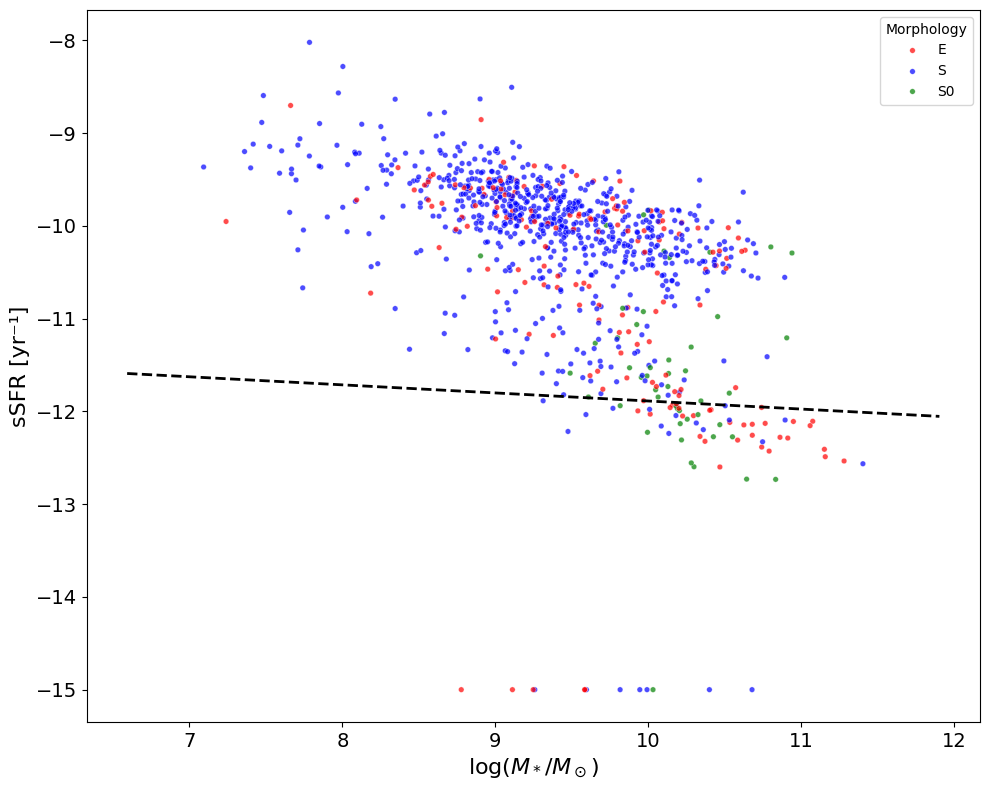

In [ ]:
fig, ax = plot_galaxy_sfr_CG(CG_Gals, f_interp, save_path='galaxy_sfr_plot_CG.pdf')

In [ ]:
f_interp = sSFR.get_decision_boundary_interp(non_quenched, fit_results)

In [ ]:
plots.classification_figure(non_quenched, sdss_df, fit_results, f_interp, 
                               fig_size=(12,8), label_fontsize=16, tick_labelsize=14, 
                               pdf_filename="galaxy_classification.pdf", 
                               quenched_value_set=-15, show=False)

NameError: name 'sdss_df' is not defined

#### Test M_BGG vs M_group

In [ ]:
def Group_agg(y):       
    """
    Compute the luminosity of the BGG, the total luminosity of the group,
    and the fraction of luminosity of the BGG in the group.
    """   
    x = y.sort_values('M_r').reset_index()
    x['my_Lum'] = au.Lum(x['M_r'])
    Lum_BGG = x.iloc[0]['my_Lum']
    Lum_group = sum(x['my_Lum'])
    FracLumBGG = Lum_BGG/Lum_group
    lgm_BGG = x.iloc[0]['lgm']
    lgm_group = np.log10(sum(10**x['lgm']))
    

    values = [Lum_BGG, Lum_group, FracLumBGG, lgm_BGG, lgm_group] 
    labels = ['Lum_BGG', 'Lum_group', 'FracLumBGG', 'lgm_BGG', 'lgm_group']
    
    
    return pd.Series(values, index=labels) 

In [ ]:
CG_groups = CG_Gals.groupby('Group').progress_apply(Group_agg).reset_index()

100%|██████████| 305/305 [00:00<00:00, 2130.57it/s]


#### sSFR vs BGG frac lum

#### No groups in the control sample yet!!!

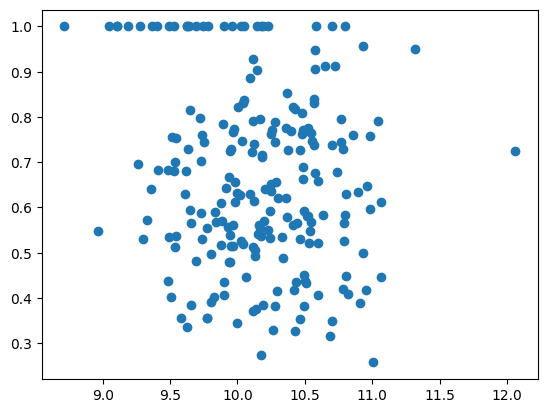

In [ ]:
plt.scatter(CG_groups['lgm_group'],CG_groups['FracLumBGG'])

In [ ]:
# from astroquery.sdss import SDSS
    
# print("Checking if GalaxyZoo table exists...")
# # Try a simple test query to see if the GalaxyZoo table exists
# test_query = """
# SELECT TOP 1 * 
# FROM GalaxyZoo
# """

# # Check if GalaxyZoo table exists
# try:
#     test_result = SDSS.query_sql(test_query, data_release=co.DATA_RELEASE)
#     galaxy_zoo_exists = True
#     print("GalaxyZoo table exists.")
# except Exception as e:
#     galaxy_zoo_exists = False
#     print(f"GalaxyZoo table doesn't exist or isn't accessible: {e}")


In [ ]:
# Zoo = pd.read_csv(co.DATA_PATH+'gz2_hart16.csv')

In [ ]:
# # 1) Inspect the unique codes (should be ~818 of them):
# unique_codes = Zoo['gz2_class'].unique()

# # 2) Build a mapping:
# mapping = {
#     code: ('spiral' if code.startswith('S')
#            else 'elliptical' if code.startswith('E')
#            else 'unsure')
#     for code in unique_codes
# }

# # 3) Apply it:
# Zoo['morph'] = Zoo['gz2_class'].map(mapping)

In [ ]:


# # 2) Define simple morphology:
# #    - If >50% volunteers saw “smooth” → elliptical
# #    - Else if >50% saw “features” **and** >50% then saw spiral arms → spiral
# #    - Else → unsure
# Zoo['morph_simple_1'] = np.where(
#     Zoo['t01_smooth_or_features_a02_smooth_debiased'] > 0.5,
#     'elliptical',
#     np.where(
#         (Zoo['t01_smooth_or_features_a06_features_or_disk_debiased'] > 0.5)
#         & (Zoo['t04_spiral_a08_spiral_debiased'] > 0.5),
#         'spiral',
#         'unsure'
#     )
# )



In [ ]:
# def fetch_dr7_to_dr8(dr7_ids, release=8, chunk_size=500):
#     """
#     Query SDSS CAS for DR7→DR8 objID mappings.

#     Parameters
#     ----------
#     dr7_ids : array-like of int
#         DR7 objIDs to look up.
#     release : int
#         SDSS data release (e.g., 8 for DR8).
#     chunk_size : int
#         Number of IDs per SQL query.

#     Returns
#     -------
#     pandas.DataFrame
#         Columns ['dr7objid','dr8objid'], indexed by dr7objid.
#     """
#     # Deduplicate & clean input
#     unique = pd.Series(dr7_ids).dropna().astype(int).unique()

#     tables = []
#     for i in range(0, len(unique), chunk_size):
#         sub = unique[i : i + chunk_size]
#         ids = ",".join(map(str, sub))
#         sql = f"""
#         SELECT
#           dr7.dr7objid AS dr7objid,
#           dr8.objID    AS dr8objid
#         FROM PhotoObjDR7 AS dr7
#         JOIN PhotoObj     AS dr8
#           ON dr7.objID = dr8.objID
#         WHERE dr7.dr7objid IN ({ids})
#         """
#         # Send to SDSS SQL REST API (via Astroquery) :contentReference[oaicite:4]{index=4}&#8203;:contentReference[oaicite:5]{index=5}
#         tbl = SDSS.query_sql(sql, data_release=release)
#         if tbl is not None and len(tbl) > 0:
#             tables.append(tbl)

#     if not tables:
#         return pd.DataFrame(columns=['dr7objid', 'dr8objid'])

#     full = Table.vstack(tables)
#     df = full.to_pandas()[['dr7objid', 'dr8objid']].drop_duplicates()
#     return df.set_index('dr7objid')


In [ ]:
# Zoo_with_dr8 = add_dr8objid(Zoo, dr7_col='dr7objid', dr8_col='objid')
# print(Zoo_with_dr8[['dr7objid', 'objid']].head())


In [ ]:
import json 

toto = [1,2,3,4,5]
tata = {'key1': 'value1', 'key2': 'value2'}
tutu = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})
tutu_json = tutu.to_json(orient='records')


# Before any entries:
with open(co.RESULTS,"w") as f:
    f.write("[\n")

# For each entry:
with open(co.RESULTS,"a") as f:
    for my_data in [toto,tata,tutu_json, tutu_str]:
        # Write the entry as a JSON object
        json.dump(my_data, f)
        f.write(",\n")

# After all entries:
# Read back, remove last comma, append closing bracket.
with open(co.RESULTS,"rb+") as f:
    f.seek(-2, os.SEEK_END)
    f.truncate()
    f.write(b"\n]")


In [ ]:
toto = [1,2,3,4,5]
tata = {'key1': 'value1', 'key2': 'value2'}
tutu = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})
tutu_json = tutu.to_json(orient='records')


# Before any entries:
with open(co.RESULTS,"w") as f:
    f.write("[\n")

for entry in [{"step": 1, "results": toto}, 
             {"step": 2, "results": tata}, 
             {"step": 3, "results": tutu_json}]:

    with open(co.RESULTS, "w") as f:
        json.dump(entry, f, indent=2)

# After all entries:
# Read back, remove last comma, append closing bracket.
with open(co.RESULTS,"rb+") as f:
    f.seek(-2, os.SEEK_END)
    f.truncate()
    f.write(b"\n]")


In [ ]:
import json
import os

toto = [1,2,3,4,5]
tata = {'key1': 'value1', 'key2': 'value2'}
tutu = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})
tutu_json = tutu.to_json(orient='records')


# os.makedirs("output", exist_ok=True)

# 1. Initialize file with opening bracket
with open(co.RESULTS, "w") as f:
    f.write("[\n")

def append_result(entry: dict):
    """Append a single JSON entry followed by a comma."""
    with open(co.RESULTS, "a") as f:
        json.dump(entry, f)
        f.write(",\n")

def finalize_results():
    """Remove trailing comma and add closing bracket."""
    # Open in read+write binary mode
    with open(co.RESULTS, "rb+") as f:
        f.seek(-2, os.SEEK_END)      # Move back over the last ",\n"
        f.truncate()                 # Cut off the comma and newline
        f.write(b"\n]")              # Write the final closing bracket

# Usage:
append_result({"step": "load",   "n_rows": 100})
append_result({"step": "clean",  "n_rows":  95})
append_result({"step": "analyze","metric": 0.42})
for entry in [{"step": 1, "results": toto}, 
             {"step": 2, "results": tata}, 
             {"step": 3, "results": tutu_json}]:
    append_result(entry)

# When all entries are added:
finalize_results()


In [18]:
Control

,specObjID,z,r_obs,objid,SFR,sSFR,lgm,h_alpha_eqw,h_beta_eqw,oiii_5007_eqw,nii_6584_eqw,h_alpha_flux,h_beta_flux,oiii_5007_flux,nii_6584_flux,log_NII_Ha,log_OIII_Hb,is_AGN,sSFR_status,sSFR_raw
0,1398488404370417664,0.025475,15.51829,1237645942905438473,0.027335,-9.810377,9.779433,-19.67467,-3.969809,-0.872456,-7.377788,558.26720,136.91850,24.18766,212.722000,-0.419030,-0.752868,False,passive,-9.810377
1,389602078101628928,0.016607,17.12731,1237648673458684342,-0.939706,-9.371545,8.363313,-45.55108,-9.669834,-21.759700,-4.476354,246.54700,78.80194,173.16440,21.620770,-1.057029,0.341922,False,passive,-9.371545
2,386305467346872320,0.032473,17.81982,1237648675066937657,-0.624127,-9.594414,8.912684,-54.41530,-14.342000,-13.844200,-10.264370,364.10740,124.24280,128.90010,72.137390,-0.703069,0.015982,False,passive,-9.594414
3,919886926993975296,0.033507,17.10886,1237655473968644471,-0.530905,-9.696272,9.104851,-53.68913,-12.058250,-19.179450,-9.301360,303.67540,83.42221,134.61170,52.836360,-0.759477,0.207801,False,passive,-9.696272
6,665490716629166080,0.041284,17.52424,1237655470209695873,-0.538196,-9.679181,9.071310,-23.50599,-6.484574,-7.642084,-4.292690,132.76040,40.73918,49.50471,23.606300,-0.750041,0.084634,False,passive,-9.679181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78705,1139536644248987648,0.033920,15.54305,1237658803107659839,-0.303529,-10.122040,9.760772,-24.84382,-5.225708,-2.748622,-7.918394,258.00250,71.86356,31.25501,78.989910,-0.514052,-0.361589,False,passive,-10.122040
78706,1172226225712687104,0.039651,16.87691,1237658802579505233,-0.186850,-9.491900,9.234746,-16.08034,-3.085219,-4.025320,-2.212265,87.22671,28.67066,31.35665,15.941600,-0.738118,0.038892,False,passive,-9.491900
78708,1380467405989373952,0.021360,17.75442,1237658493888692449,-1.027376,-9.469444,8.376643,-17.91019,-6.709258,-5.037456,-2.642560,58.95963,18.55681,24.46778,7.401768,-0.901219,0.120091,False,passive,-9.469444
78709,2016536557627926528,0.032271,17.01364,1237658492284895342,-0.408965,-9.697074,9.235690,-48.83160,-11.006830,-10.902500,-9.666684,479.44780,120.01050,122.80890,95.387400,-0.701250,0.010011,False,passive,-9.697074
